In [2]:
"""
Speaking of not understanding stuff, this doc is for looking at the measurement board's resistance 
range and precision.
"""
import numpy as np
import matplotlib.pyplot as plt


[[3.13157072e-02 3.78212159e-02 4.43267245e-02 ... 3.37074613e-01
  3.43580122e-01 3.50085630e-01]
 [1.04476843e+01 1.26180807e+01 1.47884772e+01 ... 1.12456318e+02
  1.14626715e+02 1.16797111e+02]
 [2.13063399e+01 2.57325078e+01 3.01586757e+01 ... 2.29336231e+02
  2.33762399e+02 2.38188567e+02]
 ...
 [1.12017532e+04 1.35287995e+04 1.58558458e+04 ... 1.20572931e+05
  1.22899977e+05 1.25227024e+05]
 [2.18184118e+04 2.63509572e+04 3.08835027e+04 ... 2.34848048e+05
  2.39380593e+05 2.43913139e+05]
 [2.39988580e+05 2.89843682e+05 3.39698784e+05 ... 2.58317838e+06
  2.63303348e+06 2.68288858e+06]]


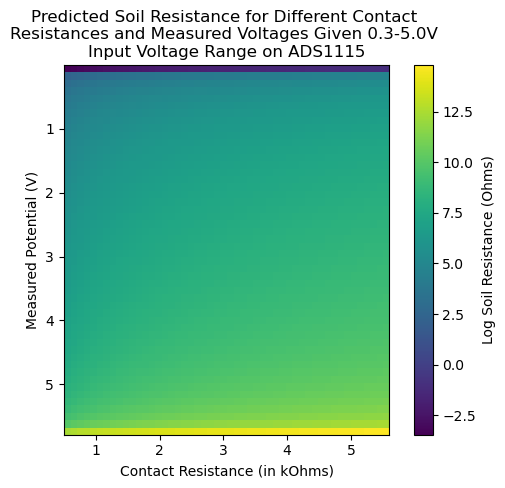

263.4263157894737

In [3]:

def r(v, i):
    return v/i

def rsoil(ps, rlead, rcontact, vmeas): 
    return (vmeas/0.4)*(rlead + rcontact)/(ps - (vmeas/0.4))


ps = 12
rlead = 1.02
rcontact = np.linspace(500, 5600)
vmeas = np.linspace(0.3e-3, 4.79)

rcs, vms = np.meshgrid(rcontact, vmeas)
soil = rsoil(ps, rlead, rcs, vms)
injcurrent = ps/(rlead + rcontact + soil)

plt.imshow(np.log(soil), extent=[min(rcontact)/1000,max(rcontact)/1000,max(vmeas)+1,min(vmeas)])
print(soil)
plt.xlabel("Contact Resistance (in kOhms)")
plt.ylabel("Measured Potential (V)")
plt.colorbar(label="Log Soil Resistance (Ohms)")
plt.title("Predicted Soil Resistance for Different Contact \nResistances and Measured Voltages Given 0.3-5.0V \nInput Voltage Range on ADS1115") 

plt.show()
rsoil(ps, rlead, 1000, 1)

In [4]:
gain = np.linspace(5/12, 1)
vmss, gains = np.meshgrid(vmeas, gain)
vactual = vmeas/gains
soil2 = rsoil(ps, rlead, 1000, vactual)
acc2 = np.vectorize(precision)(vmss)
err2 = (((rsh/vsh)*acc2)**2 + (((vsh*0.02/rsh)**2+(acc2/rsh)**2)*(rsh/vsh)**2*vmeas)**2)**0.5


plt.imshow(np.log(err2/soil), extent=[min(rcontact)/1000,max(rcontact)/1000,min(vmeas)+1,max(vmeas)])
plt.xlabel("Contact Resistance (in kOhms)")
plt.ylabel("Measured Potential (V)")
plt.colorbar(label="Soil Resistance Fractional Uncertainty (Ohms)")
plt.title("Soil Resistance Uncertainty for Different Contact Resistances \n and Measured Voltages Given 0.3-5.0V \nInput  on ADS1115") 

plt.show()
print(np.min(vactual), np.max(vactual))
print(np.max(err2/soil))

NameError: name 'vsh' is not defined

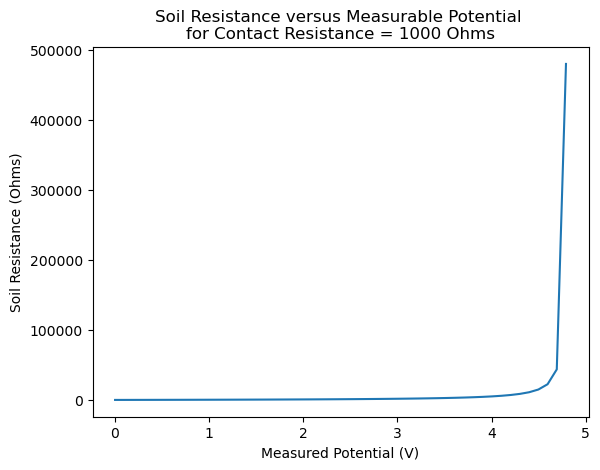

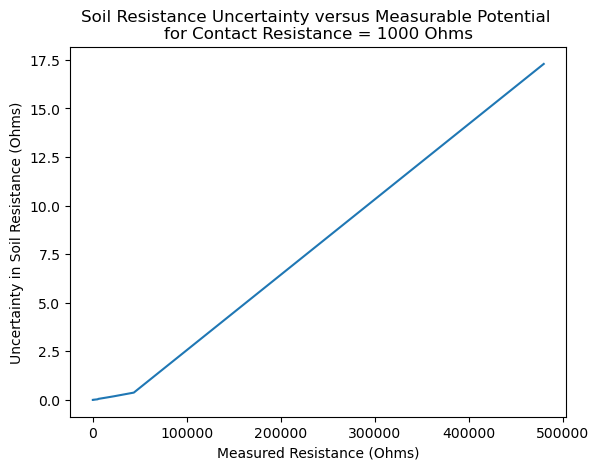

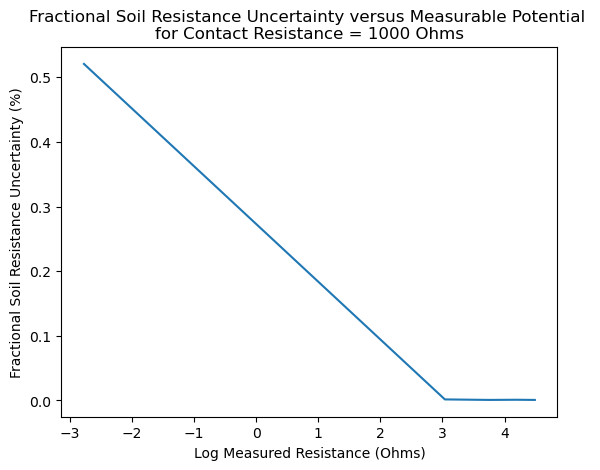

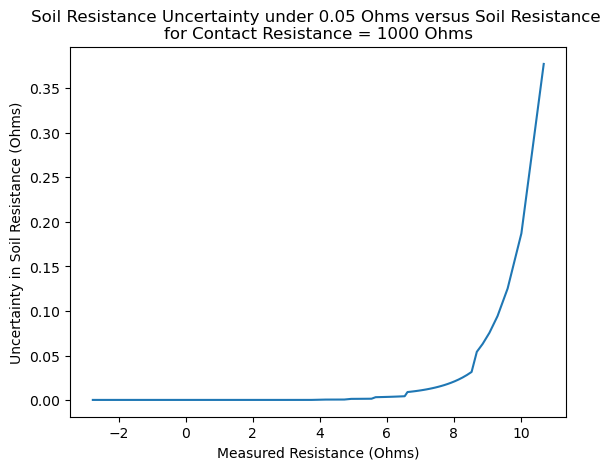

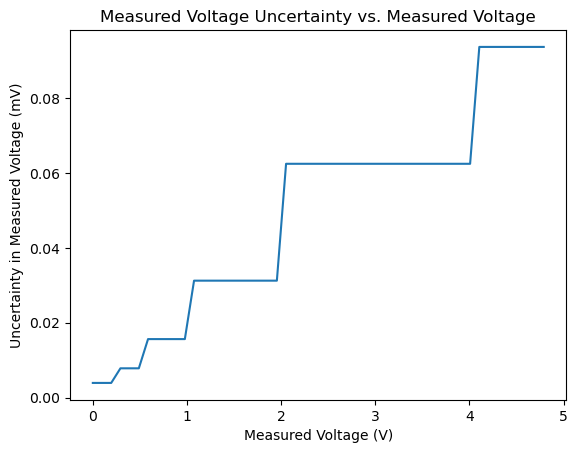

In [6]:
# Calculate error in resistance as a function of contact resistance and potential

def precision(vmeas):
    if vmeas<0.256:
        return 0.256/2**16
    
    elif (vmeas >= 0.256) & (vmeas < 0.512):
        return 0.512/2**16
    
    elif (vmeas >= 0.512) & (vmeas < 1.024):
        return 1.024/2**16
    
    elif (vmeas >= 1.024) & (vmeas < 2.048):
        return 2.048/2**16
    
    elif (vmeas >= 2.048) & (vmeas < 4.096):
        return 4.096/2**16
    
    elif (vmeas >= 4.096) & (vmeas < 6.144):
        return 6.144/2**16

rsh = 2
drsh = 0.02
check = rsoil(ps, rlead, 1000, vmeas)
vsh = 12*rsh/(rlead + 1000 + check)
acc = np.vectorize(precision)(vmeas)
err = (((rsh/vsh)*acc)**2 + (((vsh*0.02/rsh)**2+(acc/rsh)**2)*(rsh/vsh)**2*vmeas)**2)**0.5
plt.plot(vmeas, check, label="ERROR MWAHAHA")
plt.title("Soil Resistance versus Measurable Potential \nfor Contact Resistance = 1000 Ohms")
plt.xlabel("Measured Potential (V)")
plt.ylabel("Soil Resistance (Ohms)")
plt.show()

plt.plot(check, err, label="ERROR MWAHAHA")
plt.title("Soil Resistance Uncertainty versus Measurable Potential \nfor Contact Resistance = 1000 Ohms")
plt.xlabel("Measured Resistance (Ohms)")
plt.ylabel("Uncertainty in Soil Resistance (Ohms)")
plt.show()

plt.plot(np.log(check[:5]), (100*err/check)[:5], label="ERROR MWAHAHA")
plt.title("Fractional Soil Resistance Uncertainty versus Measurable Potential \nfor Contact Resistance = 1000 Ohms")
plt.xlabel("Log Measured Resistance (Ohms)")
plt.ylabel("Fractional Soil Resistance Uncertainty (%)")
plt.show()

plt.plot(np.log(check[np.where(err<0.5)]), err[np.where(err<0.5)], label="ERROR MWAHAHA")
plt.title("Soil Resistance Uncertainty under 0.05 Ohms versus Soil Resistance \nfor Contact Resistance = 1000 Ohms")
plt.xlabel("Measured Resistance (Ohms)")
plt.ylabel("Uncertainty in Soil Resistance (Ohms)")
plt.show()


plt.plot(vmeas,acc*1000, label="ERROR MWAHAHA")
plt.title("Measured Voltage Uncertainty vs. Measured Voltage")
plt.xlabel("Measured Voltage (V)")
plt.ylabel("Uncertainty in Measured Voltage (mV)")
plt.show()


In [70]:
min(check[np.where(err<0.01)])

0.06256766047877992

In [73]:
check[np.where(err==min(err))]

array([0.06256766])

In [74]:
min(err)

0.0003258732537577255

# Okay now I need to look at the circuit piece by piece and figure out where I'm going wrong.

I need to figure out:
- total range on resistance measurement
- total error on resistance measurement
- total predicted current drawn
- total predicted power dissipated

Raspberry Pi and MCP23008 are susceptible to current leakage although this shouldn't affect anything because the current is waaaay too small to turn the optocouplers on. Eg, MCP has a current leakage of 1 microamp. I don't think the resistors here should affect anything either other than power dissipation.